<a href="https://colab.research.google.com/github/hypnopump/geometric-vector-perceptron/blob/main/examples/gvp_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Get Environment Configured

In [1]:
!pip install sidechainnet proDy einops
!git clone https://github.com/hypnopump/geometric-vector-perceptron
!nvidia-smi

     |████████████████████████████████| 46.9MB 67kB/s 
     |████████████████████████████████| 6.3MB 34.5MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 2.3MB 44.9MB/s 
  Created wheel for proDy: filename=ProDy-2.0-cp37-cp37m-linux_x86_64.whl size=6653558 sha256=dd361fffeb2f1eab566e0ed0a983af457b49233722489c5b70b5efa152ac45d3
  Stored in directory: /root/.cache/pip/wheels/e2/be/52/a879e8adf713065f8f11e15c56073b311e82ecc85bbeb8b6c4
Successfully built proDy
Cloning into 'geometric-vector-perceptron'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 352 (delta 42), reused 52 (delta 31), pack-reused 281
Receiving objects: 100% (352/352), 1.52 MiB | 27.22 MiB/s, done.
Resolving deltas: 100% (204/204), done.
Fri Mar 19 22:58:13 2021       
+------------------------------

In [2]:
import torch
torch.__version__

'1.8.0+cu101'

In [3]:
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
     |████████████████████████████████| 2.6MB 6.7MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
     |████████████████████████████████| 1.5MB 7.3MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
     |████████████████████████████████| 1.0MB 351kB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
     |████████████████████████████████| 389kB 35.8MB/s 
     |████████████████████████████████| 194kB 22.3MB/s 
     |████████████████████████████████| 235kB 42.3MB/s 
     |████████████████████████████████| 2.2MB 50.6MB/s 
     |████████████████████████████████| 51kB 8.0MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-1.6.3-cp37-none-any.whl size=322719 sha256=92b485288bd8bb5fadb63849f34921cbb6fe7e9f471f87c16000b2ee0cfe7b83
  Stored in directory: /root/.cache/pip/wheels/6d/47/1e/0af8ce3e21783c3e584c22502011a33

## Connect gdrive

In [4]:
# get CASP7 data copied from drive

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
!mkdir sidechainnet_data
!cp drive/MyDrive/sidechainnet_casp7_30.pkl sidechainnet_data/sidechainnet_casp7_30.pkl

## Main code

### Set import functions and data

In [6]:
import os
import sys
import time

sys.path.append("geometric-vector-perceptron/geometric_vector_perceptron")
sys.path.append("geometric-vector-perceptron/examples")

In [7]:
import time
import torch
import numpy as np
from einops import rearrange, repeat
import matplotlib.pyplot as plt
# custom utils
from data_handler import *
from data_utils import *
# custom model
from geometric_vector_perceptron import *
# process and dataset
import gc
import joblib
from tqdm import tqdm
from functools import partial

In [8]:
# data
import sidechainnet
from sidechainnet.utils.sequence import ProteinVocabulary as VOCAB
VOCAB = VOCAB()

@> ProDy is configured: verbosity='none'


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # "cpu")

### Downloading data

In [26]:
MAX_LEN = 250
MAX_PROTS = 1500

In [27]:
# check dataloader works
dataloaders_ = sidechainnet.load(casp_version=7, with_pytorch="dataloaders")
dataloaders_.keys() # ['train', 'train_eval', 'valid-10', ..., 'valid-90', 'test']
train_examples_storer = [get_prot(dataloader_=dataloaders_, vocab_=VOCAB, max_len=MAX_LEN, verbose=0)\
                         for i in tqdm(range(3))]

# dataloaders won't work on my windows (idk why, so load examples from disk and train)
# train_examples_storer = joblib.load("sidechainnet_data/800_under_200.joblib")

SidechainNet was loaded from ./sidechainnet_data/sidechainnet_casp7_30.pkl.


100%|██████████| 3/3 [00:00<00:00,  3.53it/s]


### Data encoding dims and instantiate model


In [37]:
NEEDED_INFO = {"cutoffs": [-1e-5],
               "bond_scales": [1,2,4,8],
               "aa_pos_scales": [1,2,4,8,16,32,64,128],
               "atom_pos_scales": [1,2,4,8,16,32],
               "dist2ca_norm_scales": [1,2,4],
               "bb_norms_atoms": [0.5] # will encode 3 vectors with this
              }
# get model sizes from encoded protein
seq, true_coords, angles, padding_seq, mask = train_examples_storer[-1] 
NEEDED_INFO["seq"] = seq[:-padding_seq or None]
NEEDED_INFO["covalent_bond"] = prot_covalent_bond(seq)

# encode as needed
encoded = encode_whole_protein(seq, true_coords, angles, padding_seq, needed_info=NEEDED_INFO, free_mem=True)
x, edge_index, edge_attrs, embedd_info = encoded
embedd_info

{'bond_embedding_nums': [2],
 'bond_n_scalars': 10,
 'bond_n_vectors': 1,
 'point_n_scalars': 48,
 'point_n_vectors': 7}

In [43]:
# define model
model = GVP_Network(n_layers=4, feats_x_in=48, vectors_x_in=7,
                                feats_x_out=48, vectors_x_out=7,
                                feats_edge_in=10, vectors_edge_in=1,
                                feats_edge_out=10, vectors_edge_out=1,
                                embedding_nums=[36, 20], embedding_dims=[16,16], # from _nums to _dims
                                edge_embedding_nums=[2], edge_embedding_dims=[2], residual=True)

### Train

In [44]:
model = model.to(device) # .double()

In [45]:
noise = 1.
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [46]:
model.train()

# info records
baseline_losses = []
epoch_losses    = []
tac    = time.time()
# training run params
max_seq_len = MAX_LEN # 120
iteration   = 0
n_per_iter  = MAX_PROTS # 400
for ep in range( 2*800 ): # 1*n_per_iter
    # delete useless data from prev iter - but not in last one
    if ep > 0:
        del true_coords, angles, pre_target_x, edge_index, edge_attrs
        del scores, target_coords, pred_coords, base_coords
        del encoded, pre_target, target_aligned, pred_aligned
        gc.collect()
        
    # get input data and target - copy to gpu
    seq, true_coords, angles, padding_seq, mask = get_prot(dataloader_=dataloaders_,
                                                           vocab_=VOCAB, 
                                                           max_len=MAX_LEN, 
                                                           verbose=0)
    # define edge_attr recalculator + add seq for feature calc
    NEEDED_INFO["seq"] = seq[:-padding_seq or None]
    NEEDED_INFO["covalent_bond"] = prot_covalent_bond(seq)
    recalc_edge = partial(encode_whole_bonds, x_format = "encode",
                                              embedd_info = embedd_info,
                                              needed_info = NEEDED_INFO,
                                              free_mem = True)
    # avoid seqs above limit
    if len(seq) > max_seq_len: 
        continue
    true_coords = true_coords.to(device) # .double()
    angles = angles.to(device)           # .double()
    # target is the position of every atom (unit_vec, norm_scale)
    pre_target = encode_whole_protein(seq,
                                      true_coords,
                                      angles,
                                      padding_seq,
                                      needed_info=NEEDED_INFO, free_mem=True)
    pre_target_x, _, _, embedd_info = pre_target
    # encode as needed (noise mask)
    encoded = encode_whole_protein( seq,
                                    true_coords + noise*torch.randn_like(true_coords),
                                    angles,
                                    padding_seq,
                                    needed_info=NEEDED_INFO, free_mem=True)
    x, edge_index, edge_attrs, embedd_info = encoded
    batch = torch.tensor([0 for i in range(x.shape[0])], device=device).long()
    
    # add position coords
    cloud_mask = scn_cloud_mask(seq[:-padding_seq or None])
    # cloud is all points, chain is all for which we have labels
    chain_mask = (mask[:-padding_seq or None].unsqueeze(-1) * cloud_mask)
    flat_chain_mask = rearrange(chain_mask.bool(), 'l c -> (l c)')
    cloud_mask = cloud_mask.bool()
    flat_cloud_mask = rearrange(cloud_mask, 'l c -> (l c)')
    
    # predict
    scores = model.forward(x, edge_index, batch=batch, edge_attr=edge_attrs,
                           recalc_edge=recalc_edge, verbose = False)
    # format pred and target
    target = from_encode_to_pred(pre_target_x, embedd_info=embedd_info, needed_info=NEEDED_INFO)
    pred   = from_encode_to_pred(scores, embedd_info=embedd_info, needed_info=NEEDED_INFO)
    base   = from_encode_to_pred(x, embedd_info=embedd_info, needed_info=NEEDED_INFO)
    # MEASURE ERROR
    
    # option 1: loss is MSE on output tokens
    # loss_ = (target-pred)**2
    # loss  = loss_.mean()
    
    # option 2: loss is RMSD on reconstructed coords - unit vector + norm
    target_coords = target[:, 3:4] * target[:, :3] #  * (1 / torch.norm(target[:, :3], dim=-1, keepdim=True) )
    pred_coords   = pred[:, 3:4] * pred[:, :3] # * ( 1 / torch.norm(pred[:, :3], dim=-1, keepdim=True) )
    base_coords   = base[:, 3:4] * base[:, :3] # * ( 1 / torch.norm(base[:, :3], dim=-1, keepdim=True) )
    ## # measure error : align - sometimes svc fails - idk why
    try:
        pred_aligned, target_aligned = kabsch_torch(pred_coords.t(), target_coords.t()) # (3, N)
        base_aligned, _ = kabsch_torch(base_coords.t(), target_coords.t())
        loss = ( (pred_aligned.t() - target_aligned.t())[flat_chain_mask[flat_cloud_mask]]**2 ).mean()**0.5
        loss_base = ( (base_aligned.t() - target_aligned.t())[flat_chain_mask[flat_cloud_mask]]**2 ).mean()**0.5 
    except:
        pred_aligned, target_aligned = None, None
        print("svd failed convergence, ep:", ep)
        loss = ( (pred_coords.t() - target_coords.t())[flat_chain_mask[flat_cloud_mask]]**2 ).mean()**0.5
        loss_base = ( (base_coords - target_coords)[flat_chain_mask[flat_cloud_mask]]**2 ).mean() **0.5
    # not aligned: # loss = ((pred_coords - target_coords)**2).mean()**0.5 
    
    # back pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # records / prints
    iteration += 1
    epoch_losses.append( loss.item() )
    baseline_losses.append( loss_base.item() )
    if iteration % 10 == 1:
        tic = time.time()
        print("BATCH: {0} / {1}, loss: {2}, baseline_loss: {3}, time: {4}".format(iteration, n_per_iter,
                                                                                  epoch_losses[-1],
                                                                                  baseline_losses[-1],
                                                                                  tic-tac))
        tac = time.time()
    if iteration % n_per_iter == (n_per_iter-1):
        print("---------------------------------")

BATCH: 1 / 1500, loss: 8.787063598632812, baseline_loss: 1.0089645385742188, time: 0.41179537773132324
BATCH: 11 / 1500, loss: 12.443007469177246, baseline_loss: 0.9984539747238159, time: 6.126695871353149
BATCH: 21 / 1500, loss: 8.880804061889648, baseline_loss: 1.0016379356384277, time: 6.059038162231445
BATCH: 31 / 1500, loss: 5.779268741607666, baseline_loss: 0.9966602325439453, time: 5.961790084838867
BATCH: 41 / 1500, loss: 5.944030284881592, baseline_loss: 0.9799021482467651, time: 5.890277862548828
BATCH: 51 / 1500, loss: 7.628724098205566, baseline_loss: 0.998543381690979, time: 5.942240953445435
BATCH: 61 / 1500, loss: 9.162677764892578, baseline_loss: 0.9723517894744873, time: 6.139096021652222
BATCH: 71 / 1500, loss: 6.095966339111328, baseline_loss: 1.003954529762268, time: 6.2203688621521
BATCH: 81 / 1500, loss: 5.751498699188232, baseline_loss: 1.0071152448654175, time: 5.902956485748291
BATCH: 91 / 1500, loss: 12.562439918518066, baseline_loss: 0.9955388307571411, time:

In [47]:
# expected loss without denoising - recorded inside training loop
np.mean(baseline_losses) 

0.9988327298685908

### Train plot

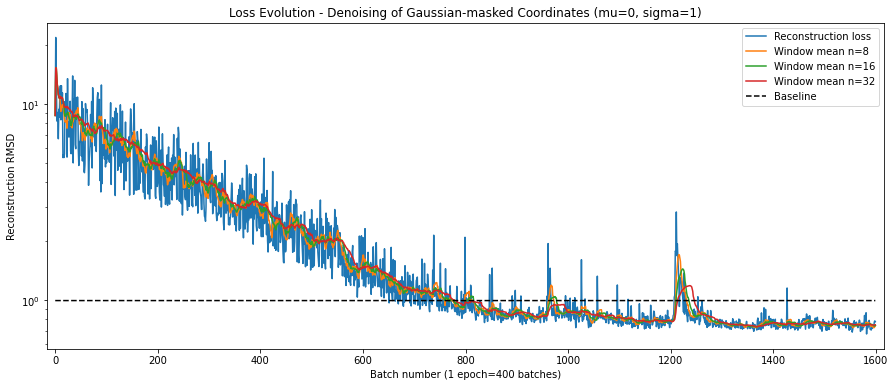

In [48]:
plt.figure(figsize=(15,6))
plt.title("Loss Evolution - Denoising of Gaussian-masked Coordinates (mu=0, sigma=1)")
plt.plot(epoch_losses, label="Reconstruction loss")

for window in [8,16,32]:
    plt.plot([np.mean(epoch_losses[:window][0:i+1]) for i in range(min(window, len(epoch_losses))) ] + \
             [np.mean(epoch_losses[i:i+window+1]) for i in range(len(epoch_losses)-window)], 
             label="Window mean n={0}".format(window))

plt.plot(np.ones(len(epoch_losses)) * np.mean(baseline_losses), "k--", label="Baseline")
    
# plt.yscale("log")
plt.xlim(-0.01*len(epoch_losses),1.01*len(epoch_losses))
plt.yscale("log")
plt.ylabel("Reconstruction RMSD")
plt.xlabel("Batch number (1 epoch=400 batches)")
plt.legend()
plt.show()

In [49]:
unfiltered = from_encode_to_pred(x, embedd_info=embedd_info, needed_info=NEEDED_INFO)
# reconstruct coordinates
target_coords = target[:, :3] * target[:, 3:4]
unfiltered_coords = unfiltered[:, :3] * unfiltered[:, 3:4]
print("MSE baseline coords: ", ((unfiltered_coords - target_coords)**2).mean()**0.5 ) 

MSE baseline coords:  tensor(0.9877, device='cuda:0')


In [50]:
# unfiltered = from_encode_to_pred(scores, embedd_info, needed_info=NEEDED_INFO)
# reconstruct coordinates
target_coords = target[:, :3] * target[:, 3:4]
sample_pred_coords = pred[:, :3] * pred[:, 3:4]
# rotate / align
pred_aligned, target_aligned = kabsch_torch(sample_pred_coords.t(), target_coords.t()) # (3, N)
print("MSE between reconstructed coords: ", ((pred_aligned - target_aligned)**2).mean()**0.5 ) 

MSE between reconstructed coords:  tensor(0.7790, device='cuda:0', grad_fn=<PowBackward0>)


In [51]:
(unfiltered[:, 3:4] - target[:, 3:4]).view(-1).mean(), \
(pred[:, 3:4] - target[:, 3:4]).view(-1).mean(), \
torch.norm(unfiltered[:, :3] - target[:, :3], dim=-1).view(-1).mean(), \
torch.norm(pred[:, :3] - target[:, :3], dim=-1).view(-1).mean()

(tensor(0.0571, device='cuda:0'),
 tensor(0.0758, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.0194, device='cuda:0'),
 tensor(0.0312, device='cuda:0', grad_fn=<MeanBackward0>))

## Protein Plots

In [52]:
scaffs  = build_scaffolds_from_scn_angles(seq[:-padding_seq or None], angles[:-padding_seq or None].cpu())
wrapper = torch.zeros(*scaffs["cloud_mask"].shape, 3).cpu()
# rebuild target
target_rebuilt = wrapper.clone()
target_rebuilt[scaffs["cloud_mask"].cpu()] = true_coords[:-14*padding_seq or None][scaffs["cloud_mask"].cpu().view(-1)].cpu()
# rebuild encoded-decoded
pre_target_rebuilt = wrapper.clone()
pre_target_rebuilt[scaffs["cloud_mask"].cpu()] = target_aligned.t().cpu()
# build input coords (w/out sidechain)
input_rebuilt = wrapper.clone()
input_rebuilt[scaffs["cloud_mask"].cpu()] = base_aligned.t().cpu()
# build predicted
pred_rebuilt = wrapper.clone()
pred_rebuilt[scaffs["cloud_mask"].cpu()] = pred_aligned.t().cpu()

In [53]:
#@title
# label
sb = sidechainnet.StructureBuilder( torch.tensor([AAS.index(x) for x in seq[:-padding_seq]]),
                                    crd=rearrange(pre_target_rebuilt, 'l c d -> (l c) d') ) # pred_rebuilt
sb.to_3Dmol()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [54]:
#@title
# masked
sb = sidechainnet.StructureBuilder( torch.tensor([AAS.index(x) for x in seq[:-padding_seq]]),
                                    crd=rearrange(input_rebuilt, 'l c d -> (l c) d') ) # pred_rebuilt
sb.to_3Dmol()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [55]:
#@title
# reconstructed
sb = sidechainnet.StructureBuilder( torch.tensor([AAS.index(x) for x in seq[:-padding_seq]]),
                                    crd=rearrange(pred_rebuilt, 'l c d -> (l c) d') ) # pred_rebuilt
sb.to_3Dmol()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol